## Rapidly exploring random trees

![](imgs/RRT.png)

![](imgs/RRT-vis.png)

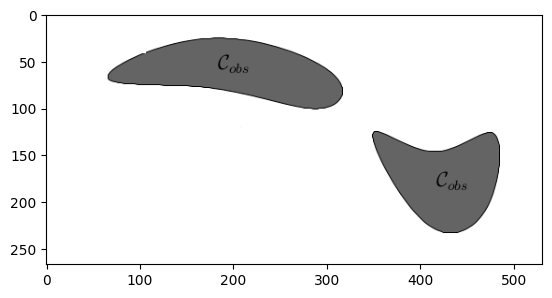

In [1]:
import numpy as np
import random
random.seed(1004)
np.random.seed(1004)
from PIL import Image
import matplotlib.pyplot as plt
# I removed the graph lines from the map above using photoshop and 
# saved only the obstacles. Load that map as a png file.
# It is color image; convert it to grayscale.
img_gray = Image.open("imgs/RRT-map.png").convert('L')
# convert the image to a numpy array
img = np.asarray(img_gray)
fig, ax = plt.subplots()
ax.imshow(img, cmap='gray') # plot the image

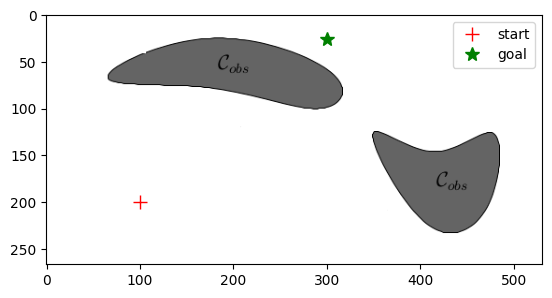

In [2]:
# Pick some arbitray start and goal points
goal = (300., 25.)
start = (100., 200.)
fig, ax = plt.subplots()
ax.imshow(img, cmap='gray') # Plot the image again
ax.plot(start[0], start[1], 'r+', markersize=10, label='start') 
ax.plot(goal[0], goal[1], 'g*', markersize=10, label='goal')
ax.legend()

## We have a problem to solve
We want to find the shortest path from start to goal in the continuous domain while avoiding obstacles.

### Rapidly exploring random trees

The main idea of the algorithm is:
1. Initialize an empty graph with the start point
2. While not done:
   
    a. Sample points on the chosen area. If the point is obstacle area, continue to the next iteration.
   
    b. Connect the sampled point to the nearest point (vertex or edge) on the graph, as long as the connecting line does not pass through the obstacle.

In [3]:
# Need img as the map representation
assert img is not None

# 1. Initialize an empty graph with the start point
G_adjacency_list = { start : [] }
Npts = 1 # we are going to sample 100 points, but start with 1 point
pt_min, pt_max = np.array([0, 0]), np.array([img.shape[1], img.shape[0]])
# 2. While not done:
for i in range(Npts):
    # 2.a Sample points on the chosen area. 
    # If the point is obstacle area, continue to the next iteration.
    random_pt = np.random.rand(2) * (pt_max - pt_min) + pt_min

random_pt

array([ 20.68332004, 228.68439464])

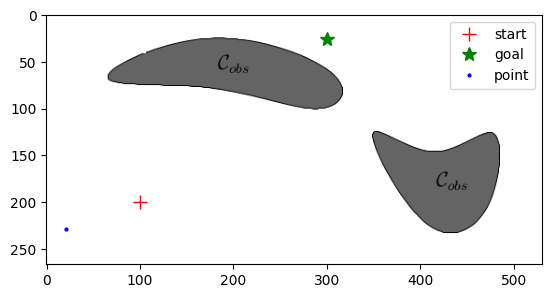

In [4]:
# Let's plot this point
def plot_map(ax, img, goal, start):
    ax.imshow(img, cmap='gray') # Plot the image again
    ax.plot(start[0], start[1], 'r+', markersize=10, label='start') 
    ax.plot(goal[0], goal[1], 'g*', markersize=10, label='goal')
    ax.legend()
    return ax
fig, ax = plt.subplots()
plot_map(ax, img, goal, start)
ax.plot(random_pt[0], random_pt[1], 'bo', markersize=2, label='point')
ax.legend()

In [5]:
# check the color of image at the random_pt
# Note that I have used y-coordinate for rows and
# x-coordinate for cols
random_pt_int = np.round(random_pt).astype(dtype=np.int64)
img[random_pt_int[1], random_pt_int[0]]

255

In [6]:
# 255 means the color is white, which means the point is in free space.
# Check the color of (200, 50)
img[50, 200]

100

In [7]:
# 100 is darker than 255. 
# Our collision check is checking for the color. 
# I pick the threshold between 100 and 255 arbitrarily as 
# 200
def do_points_collide(img, pts):
    # threshold between white (255) and gray (100) color
    threshold = 200
    pts = np.round(pts).astype(dtype=np.int64)
    in_img = ((0 <= pts) & (pts < np.array((img.shape[1], img.shape[0])))).all(axis=-1)
    dummy_pts = pts.copy()
    out_of_img = ~in_img
    dummy_pts[~in_img] = 0
    return (out_of_img) | (img[dummy_pts[..., 1], dummy_pts[..., 0]] < threshold)

def does_point_collide(img, pt):
    return do_points_collide(img, pt)

# Lets check our function again
# For a collision free point
assert does_point_collide(img, np.array([20.68332004, 228.68439464])) == False
# For a collision point
assert does_point_collide(img, np.array([200., 50.])) == True

We are going to go back to our incomplete algorithm and add collision check

In [8]:
# Need img as the map representation
assert img is not None
# 1. Initialize an empty graph with the start point
G_adjacency_list = { start : [] }

Npts = 1 # we are going to sample 100 points, but start with 1 point
# Specify the bounds of the map
pt_min = np.array([0, 0])
pt_max = np.array([img.shape[1], img.shape[0]])

# 2. While not done
for i in range(Npts):
    # 2.a Sample points on the chosen area. 
    random_pt = np.random.rand(2) * (pt_max - pt_min) + pt_min

    # If the point is obstacle area, continue to the next iteration.
    if does_point_collide(img, random_pt):
        continue

    # 2.B Connect the sampled point to the nearest point (vertex or edge) 
    # on the graph, as long as the connecting line does not pass through the obstacle.

    
    

# Finding the nearest vertex or edge on graph

There are faster algorithms to do this where we can maintain a [k-d tree](https://en.wikipedia.org/wiki/K-d_tree) and lookup the nearest vertex in $O(log(|V|))$ time. 

However, we are going to go with brute force approach and loop over all the vertices to find the closest vertex, which is $O(|V|)$.

In [9]:
vertices = list(G_adjacency_list.keys())
vertices_np = np.asarray(vertices) # N x 2
diff_vec = (vertices_np - random_pt) # N x 2
dists_per_vec = np.sqrt((diff_vec**2).sum(axis=-1)) # N
closest_vertex = vertices[np.argmin(dists_per_vec)]
closest_vertex

(100.0, 200.0)

Let's make the above code a function and stress test it a bit. 

In [10]:
def find_nearest_vertex(G_adjacency_list, pt):
    vertices = list(G_adjacency_list.keys())
    vertices_np = np.asarray(vertices) # N x 2
    diff_vec = (vertices_np - pt) # N x 2
    dists_per_vec = np.sqrt((diff_vec**2).sum(axis=-1)) # N
    closest_vertex = vertices[np.argmin(dists_per_vec)]
    return closest_vertex

In [11]:
# Create a random graph to stress test the function
def generate_random_graph(nvertices=10, # How many vertices
                          # Fraction of vertices connected to each other
                          # 1 means fully connected
                          # 0 means none connected
                          edge_density=0.2, 
                          selfedges=False, # allow self edges
                          undirected=True, # is the graph undirected
                          pt_min=np.array([0., 0.]), # range of points
                          pt_max=np.array([1., 1.])):
    D = pt_min.shape[0] # dimensions
    vertices = np.random.rand(nvertices, D) * (pt_max - pt_min) + pt_min
    G_adjacency_matrix_samples = np.random.rand(
        nvertices, nvertices)
    
    if undirected:
        matrix_edge_density = edge_density / 2
        G_adjacency_matrix_samples = np.tril(G_adjacency_matrix_samples, k=1)
        G_adjacency_matrix_samples += G_adjacency_matrix_samples.T
        G_adjacency_matrix_samples /= 2.
    # Pick the edge if the uniformly sampled prob is below edge_density
    G_adjacency_matrix = G_adjacency_matrix_samples < matrix_edge_density
    # this is equivalent to picking an edge with probbably edge_density
    G_adjacency_list = {}
    
    for vi, v in enumerate(vertices):
        G_adjacency_list[tuple(v.tolist())] = [pn 
                            for pnj, pn in enumerate(vertices)
                            if (
                                G_adjacency_matrix[vi, pnj])]
    return G_adjacency_list

generate_random_graph()

{(0.5599844056598375, 0.08048307355419271): [array([0.31588538, 0.6624027 ])],
 (0.23163629849403133, 0.2422640201141767): [],
 (0.6155000128885306, 0.6071090928914465): [array([0.65492284, 0.87138944])],
 (0.10418202913396812, 0.4258480093216789): [array([0.10418203, 0.42584801]),
  array([0.43848904, 0.71379132]),
  array([0.05886207, 0.90928569])],
 (0.6549228378857906, 0.8713894406704972): [array([0.61550001, 0.60710909])],
 (0.43848903727710387, 0.7137913238333944): [array([0.10418203, 0.42584801]),
  array([0.52181691, 0.7274295 ])],
 (0.058862068295471026, 0.9092856936737386): [array([0.10418203, 0.42584801])],
 (0.5218169119035814, 0.7274294965586153): [array([0.43848904, 0.71379132])],
 (0.4963443747862636, 0.1275522634994395): [array([0.49634437, 0.12755226])],
 (0.3158853821193849, 0.6624027003142199): [array([0.55998441, 0.08048307])]}

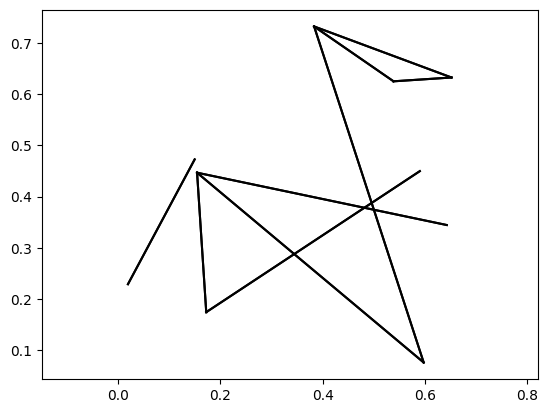

In [12]:
def plot_graph(ax, G_adjacency_list):
    ax.axis('equal')
    for v, nbrs in G_adjacency_list.items():
        for n in nbrs:
            ax.plot([v[0], n[0]], [v[1], n[1]], 'k-')
fig, ax = plt.subplots()
graph = generate_random_graph()
plot_graph(ax, graph)

Let's put a test point near different nodes and see if we 
get the right nearest vertex.

(0.5975889939537634, 0.07580321318131489)


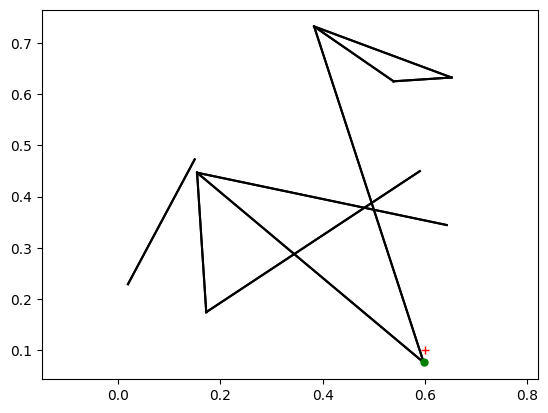

In [13]:
picked_pt = np.array((.6, .1)) # try (.6, .1) (.2, .7)
nearest_pt = find_nearest_vertex(graph, picked_pt)
print(nearest_pt)
fig, ax = plt.subplots()
plot_graph(ax, graph)
ax.plot(picked_pt[0], picked_pt[1], 'r+')
ax.plot(nearest_pt[0], nearest_pt[1], 'go', markersize=5)

Looks pretty good to me. Try different values.

But if we want to find the nearest points, we need to find the two nearest vertices. Check if the two vertices are connected. If they are connected, find the closest point on the edge. If it lies inside the edge, then break the edge to add another vertex. We are going to use np.argpartition to find top 2 nearest vertices. np.argpartition is like argsort but only top k items are 

In [14]:
def find_k_nearest_vertices(G_adjacency_list, pt, k=2):
    vertices = list(G_adjacency_list.keys())
    vertices_np = np.asarray(vertices) # N x 2
    diff_vec = (vertices_np - pt) # N x 2
    dists_per_vec = np.sqrt((diff_vec**2).sum(axis=-1)) # N
    topk = np.argpartition(dists_per_vec, k)[:k]
    closest_vertices = vertices_np[topk]
    return closest_vertices
find_k_nearest_vertices(graph, random_pt)

array([[0.65197159, 0.63276745],
       [0.53870004, 0.62530759]])

[[0.38350069 0.73248716]
 [0.15002464 0.47268691]]


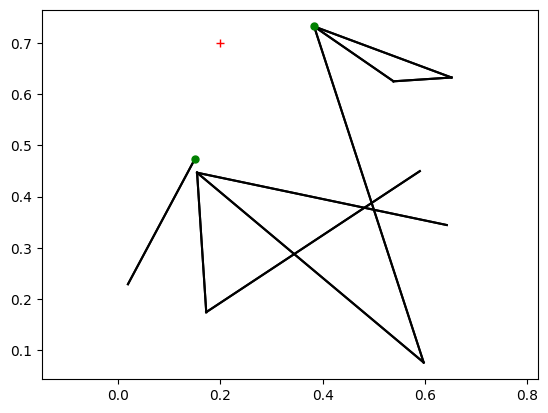

In [15]:
picked_pt = np.array((.2, .7)) # try (.6, .1) (.2, .7)
nearest_pts = find_k_nearest_vertices(graph, picked_pt)
print(nearest_pts)
fig, ax = plt.subplots()
plot_graph(ax, graph)
ax.plot(picked_pt[0], picked_pt[1], 'r+')
ax.plot(nearest_pts[:, 0], nearest_pts[:, 1], 'go', markersize=5)

In [16]:
def closest_point_on_line_segs(edges, pt):
    assert edges.shape[-2] == 2
    *N, _, D = edges.shape
    vs, ve = edges[:, 0, :], edges[:, 1, :]
    edge_vec = ve - vs # *N x D
    edge_mag = np.linalg.norm(edge_vec, axis=-1, keepdims=True) #  *N 
    edge_unit = edge_vec / edge_mag # *N x D
    
    # pt on edge = x = vs + t * edge_unit
    # (x - pt) @ edge_unit = 0
    # ((vs + t * edge_unit) - pt) @ edge_unit = 0
    # t = (pt - vs) @ edge_unit
    t = ((pt - vs) * edge_unit).sum(axis=-1, keepdims=True) # N x 1
    x = vs + t * edge_unit # *N x D
    dist_e = np.linalg.norm(pt - x, axis=-1)
    dist_vs = np.linalg.norm(vs - pt, axis=-1)
    dist_ve = np.linalg.norm(ve - pt, axis=-1)
    is_pt_on_edge = ((0 <= t) & (t <= edge_mag))[..., 0]
    dist_v = np.minimum(dist_vs, dist_ve)
    dist = np.where( is_pt_on_edge,
                    dist_e,
                    dist_v)
    min_idx = np.argmin(dist)
    closest_point =  (x[min_idx]
                      if is_pt_on_edge[min_idx] else vs[min_idx]
                      if (dist_vs[min_idx] < dist_ve[min_idx]) else ve[min_idx])
    return closest_point, dist[min_idx]

def closest_point_on_graph(G_adjancency_list, pt):
    vertices = list(G_adjacency_list.keys())
    edge_list = sum(
        [[(v, n) 
         for n in nbrs]
         for v, nbrs in G_adjacency_list.items()], [])
    if len(edge_list):
        return closest_point_on_line_segs(np.array(edge_list), pt)
    else:
        verticesnp = np.array(vertices)
        dists_v = np.linalg.norm(verticesnp - pt, axis=-1)
        min_idx = np.argmin(dists_v)
        closest_point_v = verticesnp[min_idx]
        return closest_point_v, dists_v[min_idx]
    
    

[[0.38350069 0.73248716]
 [0.15002464 0.47268691]]


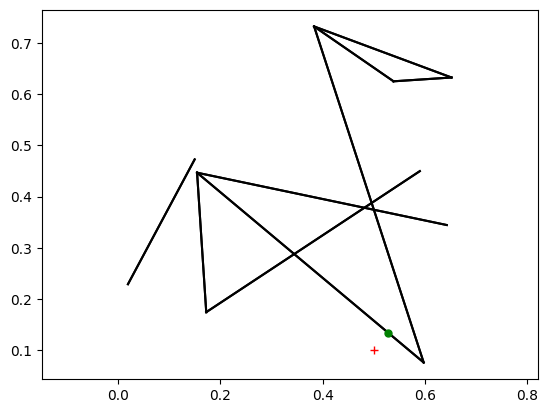

In [17]:
picked_pt = np.array((.5, .1)) # try (.4, .5) (.5, .1) (.2, .7)
edges = sum(
        [[(v, n) 
         for n in nbrs
         if np.linalg.norm(np.array(v)- np.array(n)) > 1e-5]
         for v, nbrs in graph.items()], [])
nearest_pt, dist = closest_point_on_line_segs(np.array(edges), picked_pt)
print(nearest_pts)
fig, ax = plt.subplots()
plot_graph(ax, graph)
ax.plot(picked_pt[0], picked_pt[1], 'r+')
ax.plot(nearest_pt[0], nearest_pt[1], 'go', markersize=5)

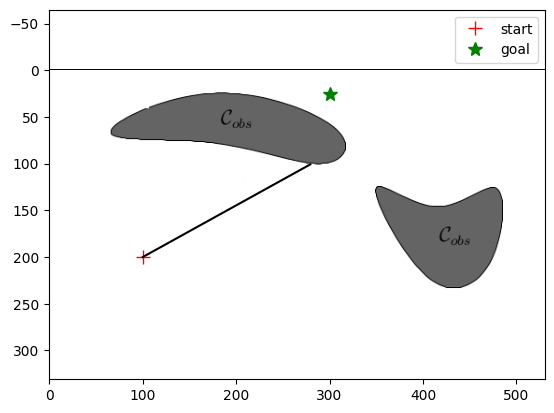

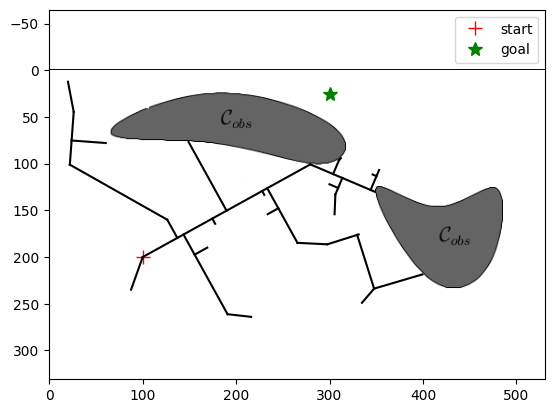

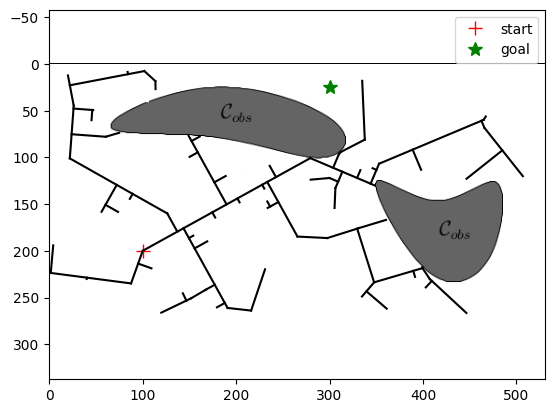

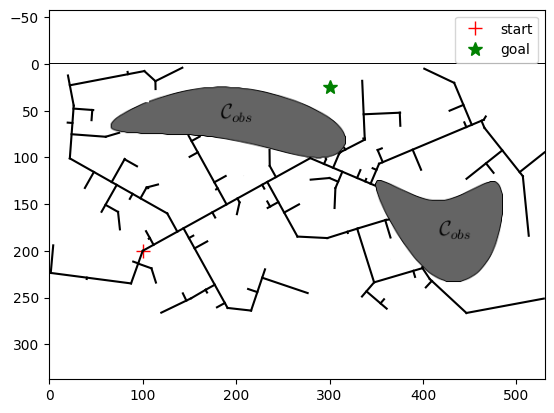

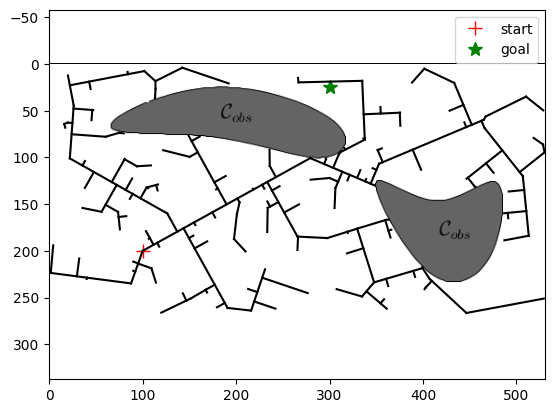

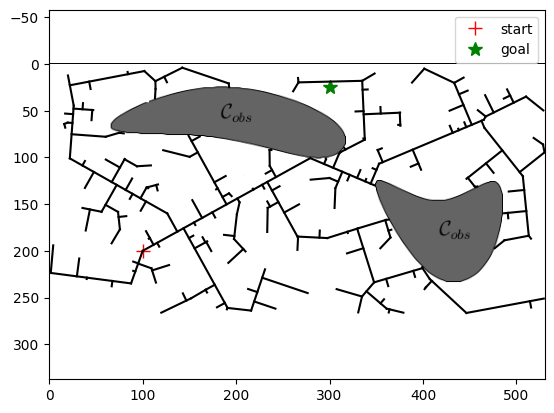

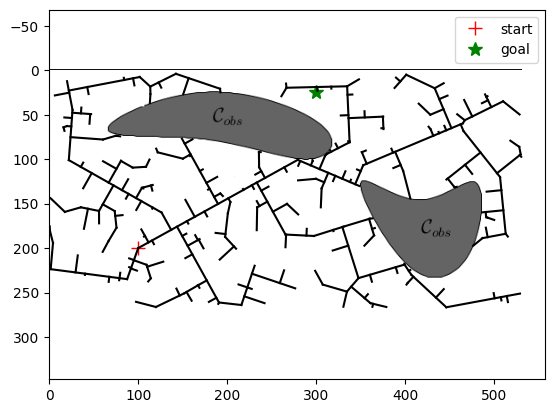

In [18]:
# Need img as the map representation
assert img is not None

Npts = 500 # we are going to sample 100 points, but start with 1 point
# Specify the bounds of the map
pt_min = np.array([0, 0])
pt_max = np.array([img.shape[1], img.shape[0]])

stepsize = 1


# 1. Initialize an empty graph with the start point
G_adjacency_list = { start : [] }

# 2. While not done
for i in range(Npts):
    # 2.a Sample points on the chosen area. 
    random_pt = np.random.rand(2) * (pt_max - pt_min) + pt_min

    # 2.B Connect the sampled point to the nearest point (vertex or edge) 
    # on the graph, as long as the connecting line does not pass through the obstacle.
    
    nearest_pt, dist = closest_point_on_graph(G_adjacency_list, random_pt)
    steps = int(np.floor(dist / stepsize))
    if steps <= 0:
        continue
    direction = (random_pt - nearest_pt) / np.linalg.norm(random_pt - nearest_pt)
    all_points = np.arange(1, steps + 1)[:, None]*stepsize*direction+ nearest_pt[None, :]
    collisions = do_points_collide(img, all_points)
    if collisions[0]:
        continue
    indices, = np.nonzero(collisions)
    first_non_colliding = all_points[indices[0]-1] if len(indices)  else random_pt
    G_adjacency_list.setdefault(
        tuple(nearest_pt.tolist()), []
                            ).append(
        tuple(first_non_colliding.tolist()))
    if i % 50 == 0:
        fig, ax = plt.subplots()
        plot_map(ax, img, goal, start)
        plot_graph(ax, G_adjacency_list)
        plt.show()